In [1]:
import os
os.environ["OPENAI_API_KEY"] = ""

in_dir = "data\\"
out_dir = "output\\"
os.makedirs(in_dir, exist_ok=True) 
os.makedirs(out_dir, exist_ok=True) 

# Text Analysis on forums form the Darkweb and surface web
To investigate the differences between forums from the DarkWeb and the surface web, we perform the following analysis:

1. Sentiment Analysis: to determine the overall sentiment expressed by users. Comparing sentiment scores between the dark web and surface web can reveal differences in the emotional profile prevalent in each environment. Analyzing sentiment patterns can help in identifying forums with a more negative, secretive, or illicit sentiment, which is typically associated with darknet platforms.

2. Linguistic Analysis: analysing the language used to identify specific linguistic patterns, vocabulary, and expressions unique to each environment. This can help understanding differences in communication styles, jargon, abbreviations or slang used on the dark web versus the surface web.

3. Named Entity Recognition (NER): to extract named entities such as person names, organizations, locations, or specific terms related to illicit activities. By comparing the frequency and context of these entities between the dark web and surface web, it could be possible to gain insights into the types of content and discussions prevalent in each environment.

4. Topic Modeling: we use Latent Dirichlet Allocation (LDA) to identify the main themes or topics discussed in both dark web and surface web forums. By comparing the distribution of topics between the two environments, it could be possible to assess the variations in the types of discussions taking place.

* Other possible analysis for future work:
  - Language Style and Stylometry: investigating the writing style and patterns within forum posts to identify unique linguistic characteristics or stylometric features. By comparing these features between the dark web and surface web, it could be possible to uncover variations in writing styles, vocabulary, or even identify potentially overlapping or connected communities.

  - Network Analysis: performing network analysis on the interactions between forum users, such as co-occurrence analysis, to identify influential users or communities. Contrasting the network structures on the dark web and surface web can reveal differences in the social dynamics and organizational structures within these communities.

In [2]:
from utils.utils import *
# Data Manipulation
import pandas as pd
pd.set_option("display.precision", 3)
pd.set_option('max_colwidth', 250)
import re
#!pip install textstat
import textstat
#pip install bs4
from bs4 import BeautifulSoup

# Data visualisation
#!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# NLP
#!pip install gensim
import gensim
from gensim.utils import simple_preprocess
import contractions
# For tokenization
import nltk
import spacy
#!spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg")
# Define custom stopwords, lowercase
custom_stopwords = ['i', 'thing', 'post', 'thread', "actually", "use"]
stopwords = nlp.Defaults.stop_words
nlp.Defaults.stop_words |= set(custom_stopwords)
#textblob.download_corpora
#!pip install spacytextblob
from spacytextblob.spacytextblob import SpacyTextBlob
nlp.add_pipe('spacytextblob')
#!pip install transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
#pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#!pip install textblob
from textblob import TextBlob
import openai
openai.api_key = os.getenv("OPENAI_API_KEY")
#!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
#pip install tensorflow
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification, pipeline

from tqdm.auto import tqdm  # for notebooks

d:\Users\camil\anaconda3\envs\absa_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Importing the data
Size of the datasets after cleaning:

| Dataset | Category                         | Original | Duplicates removal | na_removal | % from original |
|---------|---------------------------------|----------|--------------------|------------|-----------------|
| 8kun    | Hidden Surface Web (not indexed) | 1319     | 1254               | 1253       | 95%             |
| vgr     | Surface Web                     | 38469    | 28138              | 28137      | 73%             |
| 8chan   | Dark Web                        | 3210188  | 38312              | 38312      | 1%              |


In [3]:
# Importing the data
try:
  df_8kun = pd.read_parquet(os.path.join(in_dir, 'df_8kun.parquet'))
  df_8chan = pd.read_parquet(os.path.join(in_dir, 'df_8chan.parquet'))
  df_vgr = pd.read_parquet(os.path.join(in_dir, 'df_vgr.parquet'))
except:
  # Data cleaning: removal of text duplicates, na, websites
  df_8kun = pd.read_csv(in_dir+"forum_8kun.csv", index_col=0).drop(columns={'links', "post_number", "replies_to"}).convert_dtypes()
  df_8kun = df_8kun.drop_duplicates(subset=['text']).dropna(subset=['text']).reset_index(drop=True)
  df_8kun["text"] = df_8kun["text"].apply(lambda x: re.sub(r"https?:\/\/.*[\r\n]*", "", x, flags=re.MULTILINE))
  df_8kun.to_parquet(os.path.join(in_dir, 'df_8kun.parquet'))

  df_8chan = pd.read_csv(in_dir+"forum_dark_web_8chan.csv", index_col=0).drop(columns={"post_number", "replies_to"}).convert_dtypes()
  df_8chan = df_8chan.drop_duplicates(subset=['text']).dropna(subset=['text']).reset_index(drop=True)
  df_8chan["text"] = df_8chan["text"].apply(lambda x: re.sub(r"https?:\/\/.*[\r\n]*", "", x, flags=re.MULTILINE))
  df_8chan.to_parquet(os.path.join(in_dir, 'df_8chan.parquet'))

  df_vgr = pd.read_csv(in_dir+"forum_vgr.csv", index_col=0).convert_dtypes()
  df_vgr = df_vgr.drop_duplicates(subset=['text']).dropna(subset=['text']).reset_index(drop=True)
  df_vgr["text"] = df_vgr["text"].apply(lambda x: re.sub(r"https?:\/\/.*[\r\n]*", "", x, flags=re.MULTILINE))
  df_vgr.to_parquet(os.path.join(in_dir, 'df_vgr.parquet'))

print(f"df_8kun: {df_8kun.shape}\ndf_8chan: {df_8chan.shape}\ndf_vgr: {df_vgr.shape}")

df_8kun: (1253, 3)
df_8chan: (28137, 3)
df_vgr: (38312, 3)


In [4]:
try:
  df_8chan_og = pd.read_csv(in_dir+"forum_dark_web_8chan.csv", index_col=0).drop(columns={"post_number", "replies_to"}).convert_dtypes()
  print("The most repeated entries were:\n")
  display(pd.DataFrame(df_8chan_og["text"].value_counts()).head(25).T)
except:
  print("Only 1% of the original 8chan dataframe remain.")

The most repeated entries were:



,,No,thanks<doc,(checked),I LIKE YOUR ATTITUDE,nice,wew,LOL,Nice,IT'S MISTER LIZARD,...,lmao,Who?,(1),This one?,no,Thank you.,lol,Thanks anon,No.,Thanks doc.
text,5205,1314,1295,957,904,776,731,703,691,684,...,543,527,475,457,455,453,422,404,375,370


## Exploratory data analysis
In the scatterplot we can understand the data better. 
Even though there is more data for the vgr dataset, the total post count and number of unique IDs per thread was highest on 8chan.
This indicates that threads in this forum might be more engaging for its users than the ones from the vgr dataset.
The high engagement of different users per thread is even more impressive considering that the duplicates were removed, as the 8chan dataset is reduced to 1% of its original size.

In general, even the 8kun dataset had more engagement than vgr.
(As the order of magnitude is very different, select on the legend on the right the dataset you can to see)

In [5]:
# Exploratory data analysis
def create_forum_descriptive(df):
  """
  Creating an aggregated DataFrame for analysis from the column 'text'.
  Input: DataFrame with the columns: thread_title, text, poster_id
  Outputs: 
    text: all the discussions for a thread_title
    Unique_ids: Number of unique ids per thread_title
    Total_post_count: Sum of posts per thread_title
  """
  df_desc = df.groupby('thread_title').agg({"text": lambda x: ' '.join(x), 'poster_id': ['nunique', 'count']}).reset_index()
  df_desc.columns = df_desc.columns.map('_'.join)
  df_desc.columns = ['thread_title', 'text', 'Unique_ids', 'Total_post_count']
  df_desc["posts_per_user"] = df_desc["Total_post_count"]/df_desc["Unique_ids"]
  return df_desc

df_8kun_desc = create_forum_descriptive(df_8kun)
df_8chan_desc = create_forum_descriptive(df_8chan)
df_vgr_desc = create_forum_descriptive(df_vgr)

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_8kun_desc['Unique_ids'], y=df_8kun_desc['Total_post_count'], name='8kun',
 mode='markers', #marker=dict(size=df_8kun_desc['len_sum']/100000),
 text=df_8kun_desc['thread_title'], hovertemplate='%{text}<br>%{x} unique ids<br>%{y} total posts'))

fig.add_trace(go.Scatter(x=df_8chan_desc['Unique_ids'], y=df_8chan_desc['Total_post_count'], name='8chan',
 mode='markers', #marker=dict(size=df_8chan_desc['len_sum']/100000),
 text=df_8chan_desc['thread_title'], hovertemplate='%{text}<br>%{x} unique ids<br>%{y} total posts'))

fig.add_trace(go.Scatter(x=df_vgr_desc['Unique_ids'], y=df_vgr_desc['Total_post_count'], name='vgr',
 mode='markers', #marker=dict(size=df_vgr_desc['len_sum']/100000),
 text=df_vgr_desc['thread_title'], hovertemplate='%{text}<br>%{x} unique ids<br>%{y} total posts'))

# Set layout and display the figure
fig.update_layout(title='Exloratory data analysis', xaxis_title='Unique ids', yaxis_title='Total post count')
fig.show()

### Extra analysis
As 8kun is the smallest dataset some approaches were tested.
* General text analytics with a pairplot to investigate the relashionship between:
  - Total_post_count: total post count
  - words: count of words
  - gunning_fog: Gunning fog index, which is a readability metric used to estimate the years of formal education needed to understand the text. The index is based on two linguistic features: average sentence length and percentage of complex words according to the following formula:
  Gunning Fog Index = 0.4 * ((Total words / Total sentences) + (Percentage of complex words))
  - Unique_ids: How many different users engaged in the thread

  The colours refer to the total post count, as the goal of this analysis was to test whether a popular topic (with many total posts), had a different profile of amount of words, readability or unique ids.

* The [moderation API from OpenAi](https://platform.openai.com/docs/guides/moderation) was not very effective in this studied case. Two different approaches were tested: post per post analysis and for a whole topic. No content was flagged any of the moderated categories: "hate", "hate/threatening", "self-harm", "sexual", "sexual/minors", "violence", "violence/graphic". Scores were very similarly low across the whole dataset. The documentation of the API explicits that it looks for "hateful, harassing, or violent content that:
  - expresses, incites, or promotes hate based on identity
  - intends to harass, threaten, or bully an individual
  - promotes or glorifies violence or celebrates the suffering or humiliation of others

  A hypothesis is that the API only flags things that are extremes in their categories. In special the highest score for hate, albeit barely higher than other samples, was for the post "Remember to keep killing <group of people, redacted>. They are afraid, and they know that they don't have any future.". The example does indeed show hate, but even the second in this category and other categories do not present high scores according to the API.

As both these test did not seem promissing, they were not performed for the other datasets. The motivation was that the API has a limit of 60 requests per minute, making it a very slow process and not worth the results.

d:\Users\camil\anaconda3\envs\absa_env\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

d:\Users\camil\anaconda3\envs\absa_env\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

d:\Users\camil\anaconda3\envs\absa_env\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



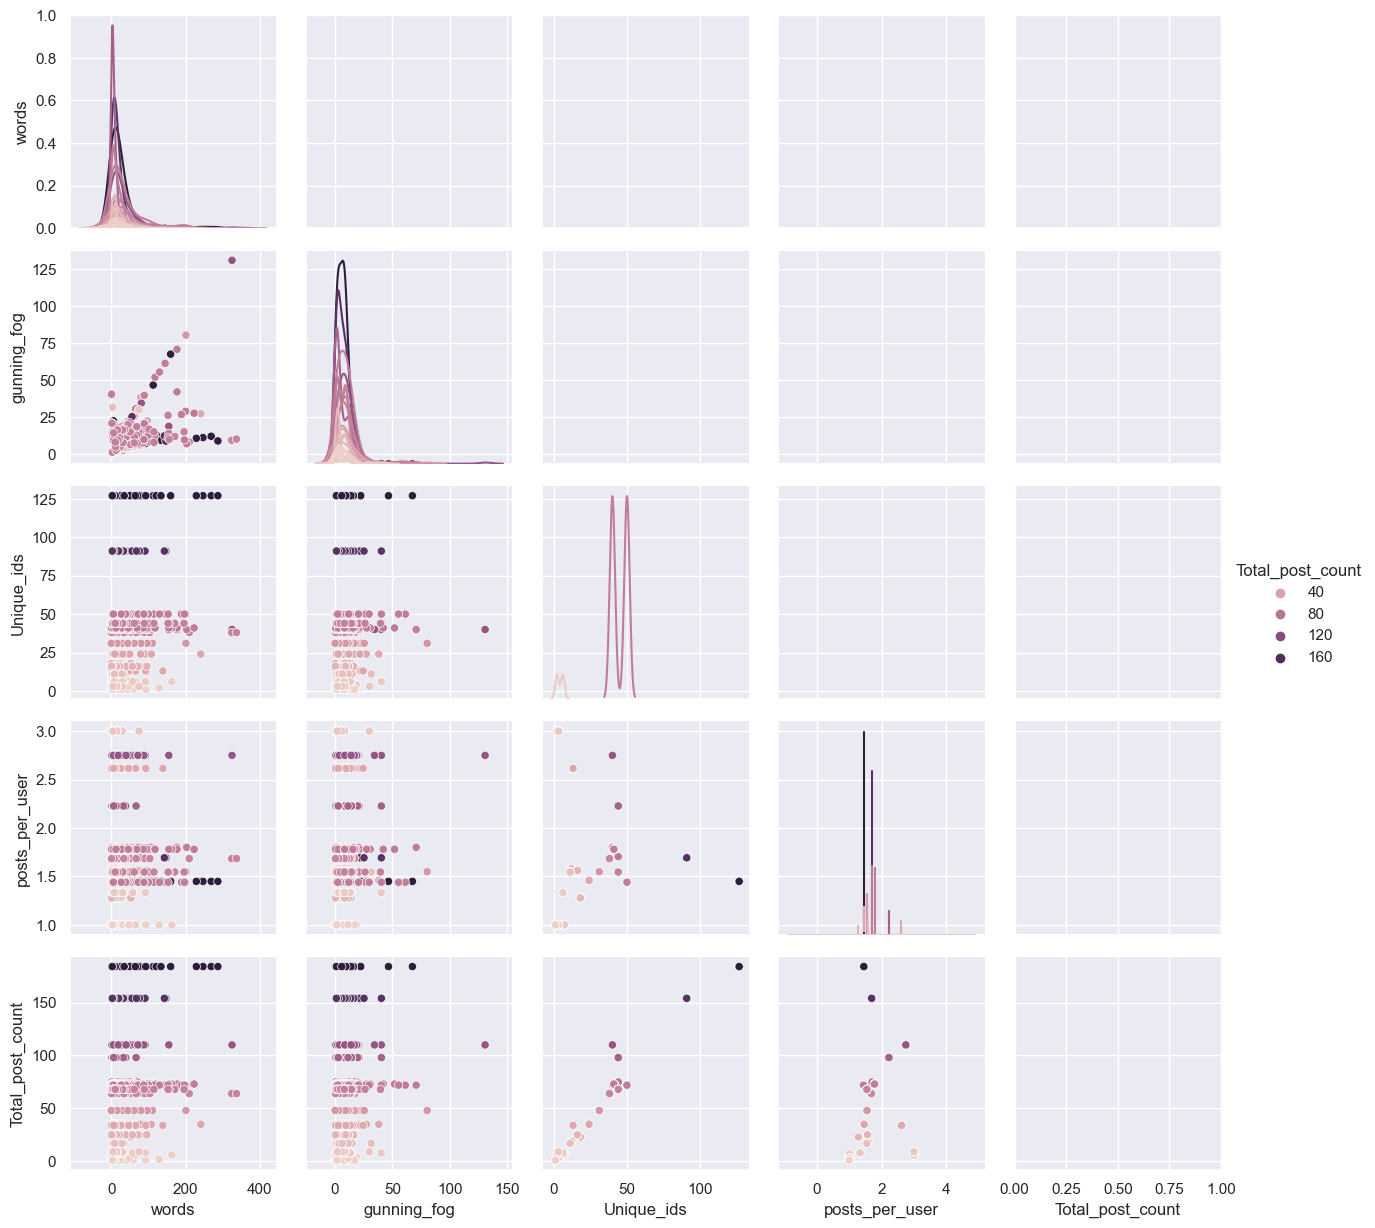

In [6]:
df = pd.merge(df_8kun, df_8kun_desc[['thread_title', 'Unique_ids', 'Total_post_count','posts_per_user']], on=["thread_title"])

# Count words
df['words'] = df['text'].apply(count_words)
# Readability
# df['text_standard'] = df['text'].apply(lambda x: textstat.text_standard(x))
# df['dale_chall_score'] = df['text'].apply(lambda x: textstat.dale_chall_readability_score(x))
df['gunning_fog'] = df['text'].apply(lambda x: textstat.gunning_fog(x)) # School grade able to read, the lower, the easier
#df['flesh_reading_ease'] = df['text'].apply(lambda x: textstat.flesch_reading_ease(x)) #0 - 100, 100 is easier
#df['reading_time'] = df['text'].apply(lambda x: textstat.reading_time(x))

# Count letters
#df['text_len'] = df['text'].str.len()

ax = sns.PairGrid(df, vars=['words', 'gunning_fog', 'Unique_ids', 'posts_per_user', 'Total_post_count'], hue='Total_post_count', diag_sharey=False)
ax.map_lower(sns.scatterplot)
ax.map_diag(sns.kdeplot)
ax.add_legend()

# Save the plot
plt.savefig(os.path.join(out_dir,"pairplot.png"))

In [7]:
# Moderation openai API
try:
  df_8kun_analysis = pd.read_parquet(os.path.join(out_dir, '8kun_analysis.parquet'))
except:
  df_8kun_desc = add_moderation_to_df(df_8kun_desc)
  df_8kun_analysis = add_moderation_to_df(df_8kun)
  df_8kun_analysis.to_parquet(os.path.join(out_dir, '8kun_analysis.parquet'))

df_8kun_analysis.sort_values("hate", ascending=False).head()["text"] #violence, sexual, self-harm, hate/threatening, violence/graphic

888                                                                                                                                        Remember to keep killing jews. They are afraid, and they know that they don't have any future.
85     Videogames are for straight, white, high IQ, non-lefatrd men only. Everyone else must be kept out, including corporate suits working for the companies that create the games, given that they are our slaves and never our equals.
477                                                                                                                                                                                                                   <Not better than CJ
956                                                                                                                               /v/ got to 25ish users per daynow it's 740/pol/ sitting at 2700 qresearch over 6000Are we being raided?
119                                                             

# Sentiment Analysis and Named Entity Recognition (NER)
* Vader takes into consideration punctuation, caps, emojis for sentiment analysis, which are very present features in this dataset. Between -1 (negative) and 1 (positive)
* Spacy texblob also shows which tokens were important for its assessment.
* [EmoRoBERTa](https://huggingface.co/arpanghoshal/EmoRoBERTa): from a labelled dataset of 58000 Reddit comments, it classifies text within the 28 emotions: admiration, amusement, anger, annoyance, approval, caring, confusion, curiosity, desire, disappointment, disapproval, disgust, embarrassment, excitement, fear, gratitude, grief, joy, love, nervousness, optimism, pride, realization, relief, remorse, sadness, surprise + neutral

* NER was performed with Spacy

* Others popular libraries for this task: Polyglot, flair, PySentiment, pattern

In [8]:
def get_list_sentiments(doc):
    sent_list = []

    sentiments = doc._.blob.sentiment_assessments.assessments
    for result in sentiments:
        for word in result[0]:
            sent_list.append(word)

    return sent_list

def get_sentiment(text, roberta):
  """
  """
  try:
    return roberta(text)[0]['label']
  except:
    return "Error: Too long text"

In [9]:
# EmoRoBERTa sentiment detection
tokenizer = RobertaTokenizerFast.from_pretrained("arpanghoshal/EmoRoBERTa")
model = TFRobertaForSequenceClassification.from_pretrained("arpanghoshal/EmoRoBERTa")

# Increase the maximum length of tokens
new_max_length = 1024
tokenizer.model_max_length = new_max_length
model.config.max_position_embeddings = new_max_length

roberta = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [10]:
def make_sentiment_analysis(df, source, out_dir = out_dir, vader_model = SentimentIntensityAnalyzer().polarity_scores, nlp = nlp, roberta = roberta, polarity_threshold = 0.25):
  """
  Makes all the sentiment analysis and NER
  """
  # Vader
  tqdm.pandas()
  df["vader"] = df["text"].progress_apply(lambda text: vader_model(text)['compound'])
  # Assign polarity based on the polarity_threshold
  df.loc[df['vader'] > polarity_threshold, 'polarity'] = 'positive'
  df.loc[df['vader'] < -1*polarity_threshold, 'polarity'] = 'negative'
  df['polarity'] = df['polarity'].fillna("neutral")
  # Spacy TextBlob
  df['nlp'] = df['text'].apply(lambda text: nlp(text))
  df['key words'] = df['nlp'].apply(lambda text: ', '.join(get_list_sentiments(text)))
  df['spacy'] = df['nlp'].apply(lambda text: text._.blob.polarity)
  # Named Entity Recognition (NER)
  df['NER'] = df['nlp'].apply(lambda x: [(ent.text, ent.label_) for ent in x.ents])
  df = df.drop(columns = "nlp")
  # Roberta
  tqdm.pandas()
  df["sentiment"] = df["text"].progress_apply(lambda text: get_sentiment(text, roberta))
  # Save
  df = df.convert_dtypes()
  df = df.astype({'polarity': 'category',
                  'vader': 'float32',
                  'spacy': 'float32',  
                  'NER': 'string',                    
                  }, errors='ignore')
  df.to_parquet(os.path.join(out_dir, source+'_analysis.parquet'))
  return df

In [11]:
source = "8kun"
try:
  df_8kun_analysis = pd.read_parquet(os.path.join(out_dir, '8kun_analysis.parquet'))
except:
  df_8kun_analysis = make_sentiment_analysis(df_8kun, source)

# Topic Modelling
* Technique used: Latent Dirichlet Allocation (LDA). This is a bag-of-words (BOW) approach that combines all words into a bag without taking into consideration the deeper semantic understanding or the order of tokens within the document. Thus text cleaning is required. The step taken are in the function "clean_text"  
* Not recommended for very short texts, so it was done per thread. It also requires text cleaning, as it is a
* The results are visualised in [source]_ldavis_[n]: A visualisation of the topic modelling from the LDA and [n] topics
* The most common words, phrases and topics are printed in this section.
* Number of topics chosen was n = 3, since the dataset was extracted from a single topic a higher number might be inadequate.

In [12]:
def clean_text(text, stop_words = nlp.Defaults.stop_words, nlp = nlp, TextBlob = False, contractions = contractions):
    '''
    Return text with the modifications:
    Normalization (lowercase), Removal of unwanted characters and stopwords and lemmatization
    ''' 
    # Tabs
    #text = re.sub(r"[\n][\t]*|[\t]", " ", text) 
    # HTML tags removal
    #text = BeautifulSoup(text, 'html.parser').get_text()
    # Normalization (lowercase)
    text = text.lower()
    # Removing mentions (@person) and Hashtags #topic, 
    #text = re.sub(r"(@|#\ z0-9]+)|([^0-9A-Za-z \t])|^rt", "", text)
    # Links: http://
    #text = re.sub(r"https?:\/\/.*[\r\n]*", "", text, flags=re.MULTILINE) 
    # Contractions
    text = contractions.fix(text)
    # Removal of unwanted characters
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', '', text)
    text = re.sub(r"'", "", text)
    # Numbers
    text = re.sub(r"[0-9]", "",text)
    # too long words: Incomprehensibilities is longest word “in common usage" or single letters
    text = re.sub(r"\b\w{25,90}\b|\b\w{1}\b", "",text)
    
    # Spelling correction
    if TextBlob:
      text = str(TextBlob(text).correct())

    # Lemmatization
    lemmatized = []
     
    doc = nlp(text)
    for token in doc:
        lemmatized.append(token.lemma_)
    
    # Removing Stopwords
    if stop_words:    
        text = " ".join([word for word in lemmatized if word not in (stop_words)])
    text = re.sub(r'\s+',' ',text)
        
    return text.strip()

In [13]:
def make_topic_modelling(df_merged, source, out_dir = out_dir, tokenizer = nltk.word_tokenize, seed = 42, num_words = 15, num_topics = 3):
    """
    """
    # Create Corpus
    df_merged['text_clean'] = df_merged['text'].apply(lambda text: clean_text(text))
    corpus_tokenized = list(df_merged['text_clean'].apply(lambda x: tokenizer(x)))

    # Making ngrams
    ngram, corpus_ngram = make_ngrams(corpus_tokenized)

    dictionary, doc_term_matrix = prepare_corpus(corpus_ngram)
    dictionary.save_as_text(os.path.join(out_dir, source+'_dictionary'))
    print(f"Length of the dictionary: {len(dictionary)}\nMost common words: ")
    print(dictionary.most_common(30))

    frequency = pd.DataFrame.from_dict(ngram.find_phrases(corpus_tokenized), orient='index', columns = ['score']).sort_values(by='score', ascending=False).reset_index()
    display(frequency.head(20).T)

    # Topic modelling
    lda_model = gensim.models.LdaMulticore(doc_term_matrix, num_topics = num_topics, id2word = dictionary,
                                    passes = 20, iterations = 200, chunksize = 2000, eval_every = None, random_state = seed)
    topic_words = lda_model.print_topics(num_topics=num_topics, num_words=num_words)
    for i,topic in enumerate(topic_words):
        print('Topic ' , i , ':', re.findall(r'"(.*?)"', topic[1]))
    return lda_model, doc_term_matrix, dictionary

lda_model, doc_term_matrix, dictionary = make_topic_modelling(df_8kun_desc, "8kun")

# Visualize the topics
num_topics = 3
LDAvis_prepared = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
pyLDAvis.save_html(LDAvis_prepared, os.path.join(out_dir, source+'_ldavis_'+str(num_topics)+'.html'))
LDAvis_prepared

Length of the dictionary: 328
Most common words: 
[('fuck', 111), ('shit', 102), ('want', 99), ('people', 85), ('I', 82), ('good', 79), ('play', 66), ('know', 65), ('think', 62), ('try', 62), ('time', 59), ('character', 57), ('nigger', 57), ('fucking', 56), ('way', 50), ('site', 49), ('work', 49), ('faggot', 44), ('board', 40), ('dead', 39), ('chan', 39), ('start', 35), ('add', 34), ('kill', 34), ('learn', 34), ('level', 34), ('need', 33), ('find', 31), ('leave', 31), ('look', 31)]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
index,final_fantasy,diversity_commissar,grammar_deck,year_ago,free_speech,year_old,stalker_mod,feel_like,video_game,sound_like,mobile_game,look_like,buy_game,play_game,game_need,people_play,shit_like
score,1.232,1.195,1.179,0.861,0.827,0.818,0.738,0.64,0.636,0.578,0.558,0.539,0.375,0.337,0.321,0.315,0.299


Topic  0 : ['fuck', 'people', 'shit', 'nigger', 'site', 'want', 'chan', 'think', 'board', 'I', 'faggot', 'fucking', 'work', 'know', 'good']
Topic  1 : ['character', 'learn', 'shit', 'I', 'try', 'play', 'good', 'start', 'level', 'way', 'know', 'fuck', '…', 'find', 'people']
Topic  2 : ['want', 'fuck', 'good', 'shit', 'play', 'I', 'time', 'people', 'way', 'weapon', 'know', 'try', 'friend', 'fucking', 'character']


d:\Users\camil\anaconda3\envs\absa_env\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=           x      y  topics  cluster    Freq
topic                                       
0      0.061  0.033       1        1  49.429
2      0.010 -0.054       2        1  34.387
1     -0.071  0.021       3        1  16.184, topic_info=          Term    Freq    Total Category  logprob  loglift
31   character  52.000   52.000  Default   30.000   30.000
122      learn  31.000   31.000  Default   29.000   29.000
249       chan  38.000   38.000  Default   28.000   28.000
211      start  32.000   32.000  Default   27.000   27.000
167       play  62.000   62.000  Default   26.000   26.000
..         ...     ...      ...      ...      ...      ...
224       time   7.964   56.300   Topic3   -4.664   -0.135
163     people   8.282   81.735   Topic3   -4.625   -0.468
223      think   7.728   59.741   Topic3   -4.694   -0.224
79        fuck   8.666  106.498   Topic3   -4.580   -0.688
231       want   7.325   94.497   Topic3   -4.748   -0.736

[200 rows x 6 columns], token_table=      Topic   Freq  Term
term                    
0         1  0.516     <
0         2  0.172     <
0         3  0.301     <
1         1  0.438     I
1         2  0.373     I
...     ...    ...   ...
243       1  0.372  yeah
243       2  0.620  yeah
285       1  0.335     …
285       2  0.293     …
285       3  0.377     …

[356 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

# 8chan

In [14]:
# Sentiment Analysis
source = "8chan"

try:
  df_8chan_analysis = pd.read_parquet(os.path.join(out_dir, source+'_analysis.parquet'))
except:
  df_8chan_analysis = make_sentiment_analysis(df_8chan, source)

In [15]:
# Topic Modelling
lda_model, doc_term_matrix, dictionary = make_topic_modelling(df_8chan_desc, source)

# Visualize the topics
LDAvis_prepared = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
pyLDAvis.save_html(LDAvis_prepared, os.path.join(out_dir, source+'_ldavis_'+str(num_topics)+'.html'))
LDAvis_prepared

Length of the dictionary: 7931
Most common words: 
[('enemy', 653), ('remake', 643), ('weapon', 575), ('pc', 545), ('site', 522), ('sonic', 497), ('switch', 465), ('japanese', 443), ('board', 438), ('girl', 436), ('ps', 435), ('attack', 434), ('able', 416), ('sell', 399), ('power', 387), ('company', 386), ('money', 385), ('image', 384), ('read', 379), ('include', 377), ('life', 373), ('devs', 365), ('map', 364), ('update', 362), ('team', 361), ('example', 353), ('hit', 351), ('dead', 349), ('list', 348), ('week', 348)]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
index,damsel_distress,los_angeles,lauren_faust,argel_tal,harry_potter,yuji_naka,ray_tracing,mortal_kombat,resident_evil,ion_fury,baldurs_gate,duke_nukem,yooka_laylee,elden_ring,donkey_kong,etrian_odyssey,mary_skelter,deus_ex,jumpy_villager,spurdo_sparde
score,1.425,1.348,1.347,1.347,1.331,1.306,1.273,1.266,1.261,1.25,1.234,1.227,1.224,1.217,1.209,1.206,1.204,1.195,1.192,1.184


Topic  0 : ['remake', 'board', 'site', 'weapon', 'enemy', 'devs', 'image', 'japanese', 'company', 'mark', 'project', 'fan', 'example', 'woman', 'girl']
Topic  1 : ['enemy', 'attack', 'mission', 'weapon', 'team', 'unit', 'stream', 'map', 'city', 'week', 'eat', 'girl', 'capture', 'battle', 'send']
Topic  2 : ['sonic', 'pc', 'switch', 'ps', 'steam', 'linux', 'console', 'window', 'sell', 'gpu', 'price', 'performance', 'file', 'deck', 'steam_deck']


d:\Users\camil\anaconda3\envs\absa_env\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=           x      y  topics  cluster    Freq
topic                                       
0     -0.035 -0.054       1        1  45.244
1     -0.069  0.044       2        1  36.538
2      0.104  0.010       3        1  18.218, topic_info=         Term     Freq    Total Category  logprob  loglift
3315    sonic  468.000  468.000  Default   30.000   30.000
3948    linux  186.000  186.000  Default   29.000   29.000
2490   remake  640.000  640.000  Default   28.000   28.000
211        pc  525.000  525.000  Default   27.000   27.000
1991   switch  447.000  447.000  Default   26.000   26.000
...       ...      ...      ...      ...      ...      ...
1412    model  115.459  267.712   Topic3   -6.088    0.862
1602    power  126.868  374.571   Topic3   -5.994    0.620
202    option  116.180  328.927   Topic3   -6.082    0.662
1979  support  112.046  294.030   Topic3   -6.118    0.738
3438   update  109.996  351.384   Topic3   -6.136    0.541

[269 rows x 6 columns], token_table=      Topic   Freq  Term
term                    
330       1  0.804    ``
330       2  0.192    ``
330       3  0.007    ``
331       1  0.322  able
331       2  0.419  able
...     ...    ...   ...
7029      2  0.027    xt
7029      3  0.945    xt
3702      1  0.045  yuzu
3702      2  0.023  yuzu
3702      3  0.929  yuzu

[561 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

# VGR

In [16]:
# Sentiment Analysis
source = "vgr"

try:
  df_vgr_analysis = pd.read_parquet(os.path.join(out_dir, source+'_analysis.parquet'))
except:
  df_vgr_analysis = make_sentiment_analysis(df_vgr, source)

In [17]:
# Topic Modeling
lda_model, doc_term_matrix, dictionary = make_topic_modelling(df_vgr_desc, source)

# Visualize the topics
LDAvis_prepared = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
pyLDAvis.save_html(LDAvis_prepared, os.path.join(out_dir, source+'_ldavis_'+str(num_topics)+'.html'))
LDAvis_prepared

Length of the dictionary: 10000
Most common words: 
[('want', 4984), ('people', 4962), ('way', 4693), ('come', 4431), ('lot', 4109), ('try', 3697), ('video_game', 3459), ('look', 3277), ('find', 3153), ('day', 3083), ('love', 3032), ('need', 2967), ('year', 2960), ('character', 2852), ('gaming', 2820), ('work', 2661), ('kind', 2650), ('new', 2582), ('start', 2546), ('buy', 2488), ('mean', 2461), ('feel', 2438), ('bad', 2370), ('sure', 2245), ('point', 2193), ('console', 2162), ('long', 2108), ('ps', 2104), ('fun', 2091), ('right', 2088)]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
index,gran_turismo,harry_potter,assassin_cree,mortal_kombat,ghost_tsushima,elden_ring,donkey_kong,tomb_raider,rick_morty,splinter_cell,prince_persia,eld_scroll,saint_row,square_enix,ratchet_clank,vice_versa,duke_nukem,tony_hawk,assasin_cree,banjo_kazooie
score,2.128,1.727,1.697,1.602,1.577,1.558,1.536,1.521,1.485,1.478,1.477,1.471,1.469,1.457,1.445,1.444,1.442,1.433,1.432,1.432


Topic  0 : ['way', 'character', 'want', 'people', 'try', 'lot', 'find', 'come', 'love', 'video_game', 'story', 'feel', 'fun', 'day', 'start']
Topic  1 : ['buy', 'want', 'console', 'people', 'year', 'come', 'ps', 'way', 'lot', 'try', 'day', 'new', 'need', 'release', 'look']
Topic  2 : ['people', 'come', 'look', 'video_game', 'lot', 'want', 'gaming', 'new', 'way', 'year', 'work', 'gta', 'love', 'series', 'old']


d:\Users\camil\anaconda3\envs\absa_env\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=           x      y  topics  cluster    Freq
topic                                       
0      0.080 -0.032       1        1  45.681
1     -0.078 -0.034       2        1  30.658
2     -0.002  0.067       3        1  23.661, topic_info=         Term      Freq     Total Category  logprob  loglift
823       buy  2432.000  2432.000  Default   30.000   30.000
698   console  2119.000  2119.000  Default   29.000   29.000
160        ps  2068.000  2068.000  Default   28.000   28.000
2163      pay   924.000   924.000  Default   27.000   27.000
207      year  2917.000  2917.000  Default   26.000   26.000
...       ...       ...       ...      ...      ...      ...
189      sure   551.626  2216.042   Topic3   -5.742    0.051
222       day   591.929  3041.596   Topic3   -5.672   -0.195
401       try   619.381  3647.649   Topic3   -5.627   -0.332
122      mean   542.349  2430.620   Topic3   -5.759   -0.059
1         bad   518.439  2339.731   Topic3   -5.804   -0.066

[307 rows x 6 columns], token_table=      Topic   Freq     Term
term                       
3806      1  0.076  account
3806      2  0.897  account
3806      3  0.024  account
3502      2  0.986   amazon
3502      3  0.008   amazon
...     ...    ...      ...
207       2  0.534     year
207       3  0.287     year
3201      1  0.046        £
3201      2  0.942        £
3201      3  0.015        £

[594 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

# Comparison
* 8kun contains the most negative sentiment emotion across the datasets.
* The biggest emotion detected was "neutral" for all datasets. 
The reason for this is that there are many plainily descriptive posts.
In the vgr dataset the most recurrent post was a simple "no".
However, the second detected emotion is different for all three.
For VGR it is "approval", which is also shown by the mainly positive sentiment detected (59.5%).
For 8chan it is "curiosity", represented by some questions for example.
For 8kun it is "anger", again displaying the overal negative sentiment.
* 8kun also contains more swear words even as the top of its dictionary.

In [18]:
# Sentiment polarity Classification
sent1 = df_8chan_analysis["polarity"].value_counts().to_frame()\
  .reset_index().rename(columns={"polarity":"8chan", "index":"polarity"})
sent2 = df_8kun_analysis["polarity"].value_counts().to_frame()\
  .reset_index().rename(columns={"polarity":"8kun", "index":"polarity"})
sent3 = df_vgr_analysis["polarity"].value_counts().to_frame()\
  .reset_index().rename(columns={"polarity":"vgr", "index":"polarity"})

sentiment_df = pd.merge(sent1, sent2, on='polarity')
sentiment_df = pd.merge(sentiment_df, sent3, on='polarity').sort_index().sort_values("polarity")

# Make vis
fig = make_subplots(rows=1, cols=3, specs=[[{"type": "pie"}, {"type": "pie"}, {"type": "pie"}]], subplot_titles=("8chan", "8kun", "vgr"))

fig.add_trace(go.Pie(labels=sentiment_df.polarity, textinfo='label+percent', textposition='inside', marker=dict(colors=["tomato", "wheat", "mediumslateblue"]), 
values=sentiment_df["8chan"]), row=1, col=1)

fig.add_trace(go.Pie(labels=sentiment_df.polarity, textinfo='label+percent', textposition='inside', marker=dict(colors=["tomato", "wheat", "mediumslateblue"]), 
values=sentiment_df["8kun"]), row=1, col=2)

fig.add_trace(go.Pie(labels=sentiment_df.polarity, textinfo='label+percent', textposition='inside', marker=dict(colors=["tomato", "wheat", "mediumslateblue"]), 
values=sentiment_df["vgr"]), row=1, col=3)


# Update layout properties for spacing and sizing
#fig.update_layout(height=400, width=900, showlegend=False)
fig.update_layout(title_text=f"Sentiment polarity")
# Show the chart
fig.show()

In [19]:
# Emotion Detection
n = 10

sent1 = df_8chan_analysis["sentiment"].value_counts().to_frame()\
  .reset_index().rename(columns={"sentiment":"8chan", "index":"sentiment"})
sent2 = df_8kun_analysis["sentiment"].value_counts().to_frame()\
  .reset_index().rename(columns={"sentiment":"8kun", "index":"sentiment"})
sent3 = df_vgr_analysis["sentiment"].value_counts().to_frame()\
  .reset_index().rename(columns={"sentiment":"vgr", "index":"sentiment"})

sentiment_df = pd.merge(sent1, sent2, on='sentiment')
sentiment_df = pd.merge(sentiment_df, sent3, on='sentiment')

# Make vis
fig = make_subplots(rows=1, cols=3, specs=[[{"type": "pie"}, {"type": "pie"}, {"type": "pie"}]], subplot_titles=("8chan", "8kun", "vgr"))

fig.add_trace(go.Pie(labels=sentiment_df.sentiment[:n], values=sentiment_df["8chan"]), row=1, col=1)

fig.add_trace(go.Pie(labels=sentiment_df.sentiment[:n], values=sentiment_df["8kun"]), row=1, col=2)

fig.add_trace(go.Pie(labels=sentiment_df.sentiment[:n], values=sentiment_df["vgr"]), row=1, col=3)


# Update layout properties for spacing and sizing
#fig.update_layout(height=400, width=900, showlegend=False)
fig.update_layout(title_text=f"Top {n} emotions detected")
# Show the chart
fig.show()

In [24]:
!conda env export > environment.yml